### **1) EDA analysis**

In [954]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use("ggplot")

In [955]:
# Load dataset
df = pd.read_excel("esg-dataset.xlsx")
df.head(4)

,Company,EGroup1,EGroup2,EGroup3,EGroup4,Ggroup,SGroup1,SGroup2,SGroup3,SGroup4,Controversy Level,Controversy Score,ESG_Loan Approval
0,1,A,A,A,A,A,A,A,D,D,Moderate Controversy Level,2.0,High
1,2,A,A,A,A,A,A,A,A,A,Low Controversy Level,1.0,High
2,3,A,A,A,A,A,A,A,A,A,Low Controversy Level,1.0,High
3,4,B,B,A,A,A,C,A,A,A,None Controversy Level,NaN,High


Plotting distribution of the *target variable* (ie. ESG_Loan Approval)

- It comes out that data for the target variable are **unbalanced**, ie. one category ("Low") is underrepresented, avoiding an optimal training of the model.

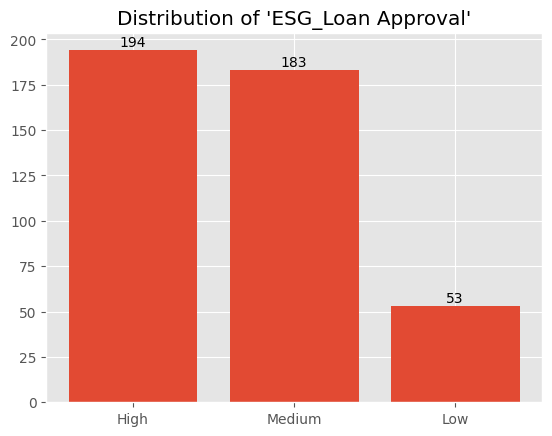

In [956]:
# For bar plot, count occurrences
count = df.groupby("ESG_Loan Approval")["Company"].count().to_dict()

# Order dict by values
count = dict(sorted(count.items(), key=lambda x:x[1], reverse=True))

plt.bar(list(count.keys()), list(count.values()))

for item in count.items():
  plt.text(item[0], item[1]+2, str(item[1]), ha="center") # Add data values labels

plt.title("Distribution of 'ESG_Loan Approval'")
plt.show()

In [957]:
# Drop unnecessary columns
df = df.drop("Controversy Level", axis=1) # Redundant label
df = df.drop("Company", axis=1)

In [958]:
# Encoding values for feature columns
map1 = {"A":4, "B":3, "C":2, "D":1}
for col in df.columns[:9]:
  df[col] = df[col].replace(map1)

In [959]:
# Encoding values for target column
map2 = {"High":3, "Medium":2, "Low":1}
df["ESG_Loan Approval"] = df["ESG_Loan Approval"].replace(map2)

Visualizing **correlation matrix** to inspect possible interactions between variables.
- "Controversy Score" negatively correlated with probability of getting a loan ("ESG_Loan Approval"), ie. when a company is "controversial" more difficutl to access credit
- Features 'EGroup1-3' and 'SGroup2-3' are particularly positively correlated with a higher likelihood of getting access to an ESG loan

Text(0.5, 23.38159722222222, 'Features')

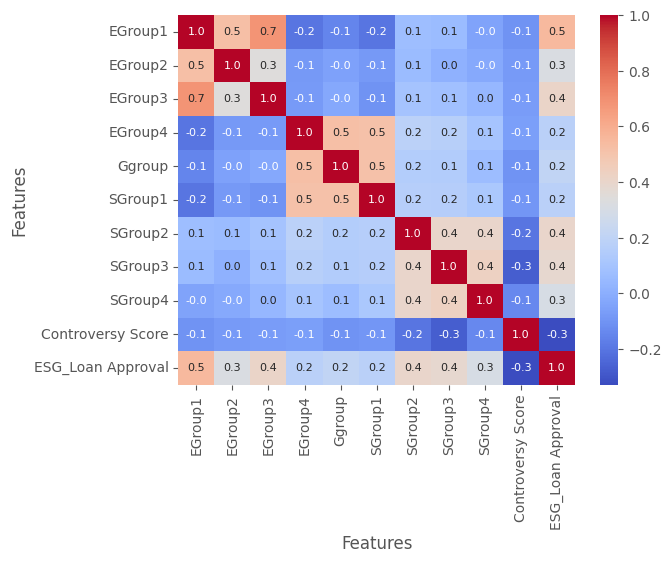

In [960]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Create the plot
cax = sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns, cmap="coolwarm", annot=True, annot_kws={"fontsize":8}, fmt=".1f")
cax.set_ylabel("Features")
cax.set_xlabel("Features")

### **2) Preprocessing: Handling Missing Values**
Problem: In "Controversy Score" 27 NA values over 430 observations

In [961]:
# 27 entries miss "Controversy Score"
df[df.isna().any(axis=1)].head()

,EGroup1,EGroup2,EGroup3,EGroup4,Ggroup,SGroup1,SGroup2,SGroup3,SGroup4,Controversy Score,ESG_Loan Approval
3,3,3,4,4,4,2,4,4,4,NaN,3
6,2,2,2,3,4,4,4,4,1,NaN,3
13,3,3,4,3,3,1,4,2,4,NaN,3
22,3,3,3,4,4,4,4,4,1,NaN,3
23,3,1,4,4,4,3,4,3,4,NaN,3


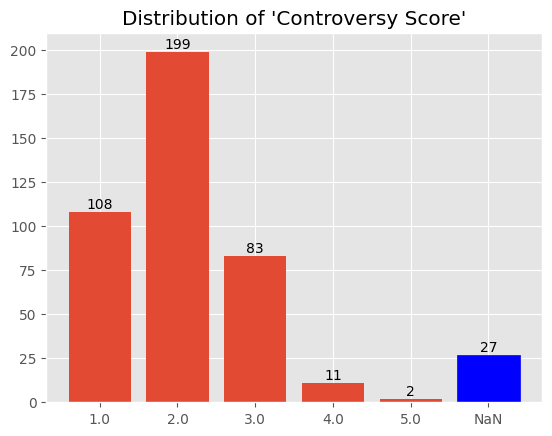

In [962]:
# Count values in "Controversy Score"
count_cs = df.groupby("Controversy Score", dropna=False).size().to_dict()

# Replace nan key entry
for key in list(count_cs.keys()):
  if pd.isna(key):
    count_cs["NaN"] = count_cs.pop(key)

# Convert all keys to strings
count_cs = {str(k): v for k, v in count_cs.items()}

# Plotting
barlist = plt.bar(list(count_cs.keys()), list(count_cs.values()))
barlist[-1].set_color("blue")
plt.ylim(0, 210)

# Add data values labels
for item in count_cs.items():
  plt.text(item[0], item[1]+2, str(item[1]), ha="center")

plt.title("Distribution of 'Controversy Score'")
plt.show()

**Approach 1: Imputation with mode**

In [963]:
mode = df["Controversy Score"].mode()[0]
df = df.fillna({"Controversy Score": mode})

***Approach 2: Dropping**

In [ ]:
df = df.dropna(subset=["Controversy Score"], axis=0)

**Approach 3: Imputation with group average**: companies are grouped by "ESG_Loan Approval" and a "Controversy Score" group-level mean is calculated

In [ ]:
group_mean = df.groupby("ESG_Loan Approval")["Controversy Score"].mean()

def fill_na_with_mean(row):
  if pd.isna(row["Controversy Score"]):
    return group_mean[row["ESG_Loan Approval"]]
  else:
    return row["Controversy Score"]

df["Controversy Score"] = df.apply(lambda x: fill_na_with_mean(x), axis=1)

### **3) Feature Selection & Split Train/Test**

Dimensionality reduction, ie. removing non-informative or redundant predictors from the model

In [964]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif # ANOVA

In [965]:
# Split features - target var
X = df.drop("ESG_Loan Approval", axis=1)
y = df["ESG_Loan Approval"]

In [966]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify= y, random_state=24)

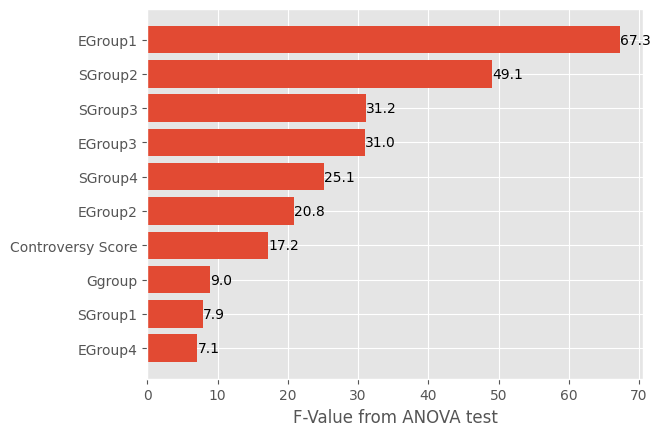

In [967]:
# ANOVA test for all features to plot
fs = SelectKBest(f_classif, k="all")
fs.fit(X_train, y_train)

p = dict(zip(X_train.columns, fs.scores_))

p_ord = dict(sorted(p.items(), key=lambda x:x[1]))
plt.barh(list(p_ord.keys()), list(p_ord.values()))
plt.xlabel("F-Value from ANOVA test")

for i in p_ord.items():
  plt.text(i[1], i[0], s=str(round(i[1], 1)), va="center")

In [968]:
# Without SMOTE, optimal number of features: 8/9
fs = SelectKBest(f_classif, k=9)
X_train_selected = fs.fit_transform(X_train, y_train)

In [969]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

### **4) Oversampling w/ SMOTE**

Before running models, synthethic oversample of smaller classes with SMOTE

In [935]:
smote_dict = {1: 80} # For class 1 returns 80 "observations"
smote = SMOTE(sampling_strategy=smote_dict, random_state=24)
X_train_selected_over, y_train_over = smote.fit_resample(X_train_selected, y_train)

### **5) Logistic Regression**

In [970]:
model = LogisticRegression(max_iter=200)

model.fit(X_train_selected, y_train)

X_test_selected = fs.transform(X_test)
y_pred = model.predict(X_test_selected)

In [971]:
# RESULTS
print(model.score(X_test_selected, y_test))
print(classification_report(y_test, y_pred))

0.8023255813953488
              precision    recall  f1-score   support

           1       0.78      0.64      0.70        11
           2       0.78      0.78      0.78        36
           3       0.83      0.87      0.85        39

    accuracy                           0.80        86
   macro avg       0.79      0.76      0.78        86
weighted avg       0.80      0.80      0.80        86



- Missing value handling: mode
- Feature selection with F-Value: drop EGroup4
- No oversampling with SMOTE
- No crossvalidation

- **Accuracy 80.23%**
- **Precision (= % of true positives) equal/over 78% for all categories**
- **F1-score (= avg over prec and recall) equal/over 70% for all caterogies**